In [1]:
# Edit this
frame_num = 40

In [2]:
import cv2
from pytube import YouTube
from pathlib import Path
import os
print("done")

done


In [3]:
save_dir = Path('../data/source/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

In [4]:
# Bruno Mars - That's What I Like
yt = YouTube("https://www.youtube.com/watch?v=PMivT7MJ41M")
print("here")
yt.streams.first().download(str(save_dir), 'mv')
#yt.streams.first().download(save_dir, 'mv')

here


'../data/source/mv.mp4'

In [5]:
cap = cv2.VideoCapture(str(save_dir.joinpath('mv.mp4')))
i = 0
while(cap.isOpened()):
    flag, frame = cap.read()
    if flag == False or i == 1000:
        break
    #cv2.imwrite(str(img_dir.joinpath('img_{i:04d}.png')), frame)
    cv2.imwrite(str(img_dir.joinpath('img_{:04d}.png'.format(i))), frame)
    i += 1
print("done")

done


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

In [7]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%load_ext autoreload
%autoreload 2

In [8]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [9]:
weight_name = openpose_dir.joinpath('network/weight/pose_model.pth')
#sys.path.insert(0, '../src/pytorch_Realtime_Multi-Person_Pose_Estimation/network/weight/pose_model.pth')

In [10]:
model = get_model('vgg19') 
temp = torch.load(weight_name)

Bulding VGG19


In [11]:
model.load_state_dict(temp)
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

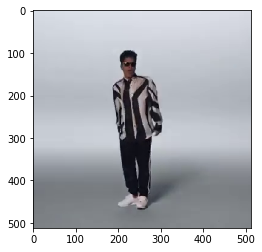

In [12]:
img_path = sorted(img_dir.iterdir())[137]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

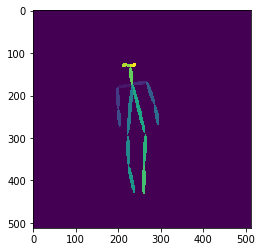

In [13]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

In [14]:
from platform import python_version
print(python_version())

3.5.3


In [15]:
test_img_dir = save_dir.joinpath('test_img')
test_img_dir.mkdir(exist_ok=True)
test_label_dir = save_dir.joinpath('test_label')
test_label_dir.mkdir(exist_ok=True)

#for idx in tqdm(range(117, 117+4)):
for idx in tqdm(range(117, 117+frame_num)):
    #img_path = img_dir.joinpath(f'img_{idx:04d}.png')
    img_path = img_dir.joinpath('img_{:04d}.png'.format(idx))

    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label = get_pose(param, heatmap, paf)
    cv2.imwrite(str(test_img_dir.joinpath('img_{:04d}.png'.format(idx))), img)
    cv2.imwrite(str(test_label_dir.joinpath('label_{:04d}.png'.format(idx))), label)
    
torch.cuda.empty_cache()

100%|██████████| 40/40 [01:41<00:00,  2.63s/it]
